In [1]:
#Martina Carretta (1673930), Meritxell Carvajal (1671647)

# Fundamentals of Computer Vision: Applied Projects


This Jupyter notebook series contains the bases of the laboratories you need to develop during the semester.

The main goal of those projects is twofold: 1st is to reiterate the theoretical context of the lectures and 2nd to use those methods in adapted examples for real-world scenarios.

## Deadlines

- **Follow-up:** 26/10 15:00h
  - Jupyter executed with all the work done until the moment
- **Deliverable** 3/11 23:55h
  - Report
  - Code
  - Data

*See practicum presentation slides for more detailed information*

## Import libraries, util functions and test image loading



Libraries that you can use (not mandatory) and some auxiliar functions that could be useful on this block.

In [2]:
#!pip install imutils
import cv2
import urllib3
import numpy as np

from PIL import Image

import imutils
from matplotlib import pyplot as plt


In [3]:
def add_noise(image, noise_type, mean=0, std=0.01, amount=0.05, salt=0.5):
    """
    Add noise to an image.

    Parameters:
    - image: numpy array of shape (H, W) for grayscale or (H, W, 3) for RGB
    - noise_type: string, one of 'gaussian', 'salt_pepper', 'speckle'
    - params: dictionary containing parameters specific to the noise type

    Returns:
    - noisy_image: numpy array with added noise
    """

    if noise_type == 'gaussian':
        sigma = std**0.5
        noise = np.random.normal(mean, sigma, image.shape).astype(image.dtype)
        noisy_image = cv2.add(image, noise)

    elif noise_type == 'salt_pepper':
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * salt)
        coords = [np.random.randint(0, i-1, int(num_salt)) for i in image.shape]
        out[tuple(coords)] = 1
        # Pepper mode
        num_pepper = np.ceil(amount*image.size*(1. - salt))
        coords = [np.random.randint(0, i-1, int(num_pepper)) for i in image.shape]
        out[tuple(coords)] = 0
        noisy_image = out

    elif noise_type == 'speckle':
        noise = np.random.randn(*image.shape).astype(image.dtype)
        noisy_image = image + image * noise

    else:
        raise ValueError(f"Noise type '{noise_type}' is not supported.")

    # Clip values to be in [0, 255]
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)

    return noisy_image

def add_periodic_noise(image, frequency=5, amplitude=10):
    X, Y = np.meshgrid(np.arange(image.shape[0]),np.arange(image.shape[1]))

    noise = amplitude * np.sin(2 * np.pi * frequency * Y / image.shape[0])

    noisy_image = image + noise

    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)

    return noisy_image


# Block 1. Linear filtering
This block focuses on linear filtering, one of the foundational concepts in image processing and computer vision. We'll be delving deep into how convolution operates, the distinction between convolution and correlation, and the magic of the Fourier transform in image filtering.

### Objectives:

1. **Implement and Learn How Convolution Works:**  
   A self-implemented convolution function and its application on sample images.

2. **Use Convolution to Apply Linear Filters:**  
   Blurred and edge-detected versions of input images using your convolution function.

3. **Compare Convolution and Correlation:**  
   Implementation of correlation function and comparison with convolution.

4. **Normalized Cross-Correlation and Use for Template Matching:**  
   Function to locate a template within a larger image.

5. **Fourier Transform and Image Filtering:**  
   Filtered images emphasizing or de-emphasizing certain frequency components.

---

### Mandatory Questions:

- What is the purpose of image filtering in computer vision? Can you list some common applications?

- Why do we often use odd-sized kernels in image filtering? When we want to use even-sized filters?

- Why do we often use a flipped version of the kernel in the convolution operation?

- What is the fundamental difference between convolution and correlation? Can you demonstrate this with an example?

- How does changing the size of the kernel affect the outcome of the convolution operation?

- Explain the process of convolution and how it is used to apply a filter to an image.

- In your own words, explain the significance of the Fourier transform in image processing.

- Describe the process and the underlying principle of template matching using normalized cross-correlation.

- Why might one choose to operate in the frequency domain (using Fourier transform) instead of the spatial domain when processing an image?

- Can we remove "salt and pepper" noise with some of those linear filters?  


### Optional Deep Dive Questions:

- Besides convolution, what are other methods to apply filters to an image? Can you compare and contrast these methods?

- Explore the concept of separable kernels. What benefits do they provide in convolution?

- What is the purpose of the padding in the convolution operation, and what are the different types of padding? Explain also the purpose of stride and how this affects the output?

- Explain which types of filters might be important for a real-scenario application (e.g., self-driving car vision system, medical image analysis).

- What are the limitations of linear filters when it comes to noise reduction? Are there scenarios where they might not be ideal?

- How would might you extend the concepts of convolution to color images? Which complexities arise when dealing with multiple channels?

- Fourier transform is used in various fields outside of image processing. Can you find and explain an application outside of computer vision?

- Explore and explain the difference between the discrete Fourier transform (DFT) and the fast Fourier transform (FFT). Why might FFT be preferred in many applications?


## Convolution operation



#### Objective:
Implement the convolution operation by hand and compare it with standard library functions. Also, manipulate image sizes through upsampling and downsampling using convolution. The focus will be on handling edge cases and experimenting with various kernels.

---

#### Guideline:
1. Implement a function to perform the convolution operation on an image. Make sure to handle edge cases and allow for different kernel sizes. DO NOT USE LIBRARY IMPLEMENTATIONS.
2. Develop methods for upsampling and downsampling images using your convolution function.
3. Experiment with your convolution function by applying different kernels on various images.
4. Compare your hand-implemented convolution outcomes with standard library methods such as OpenCV's `filter2d` and SciPy's `convolve`.

---

#### Expected results:
- Your hand-implemented convolution, upsampling, and downsampling code.
- Resized images at scales: (2x, 0.5x).

In [4]:
def convolution(image, kernel, stride=1, padding=0):
    #change of kernel with list comprehension
    kernel_2 = [row[::-1] for row in kernel]
    
    # Get dimensions of the image and kernel
    image_h, image_w = image.shape
    kernel_h, kernel_w = kernel.shape
    
    # Calculate dimensions of the output
    if kernel_h % 2 == 0: # We need different output sizes depending on if the kernel is even-number sized or not
        output_h = (image_h - kernel_h  + 2 * padding) // stride
        output_w = (image_w - kernel_w  + 2 * padding) // stride
    else:
        output_h = (image_h - kernel_h  + 2 * padding) // stride + 1
        output_w = (image_w - kernel_w  + 2 * padding) // stride + 1
    
    # temp is the original image with the necessary padding
    temp = np.full((image_h + 2*padding, image_w + 2*padding), 0)
    temp [padding:image_h + padding, padding:image_w + padding] = image #Padding of 1 and start at 1 finish at 10+1 = 11
    temp_h, temp_w = temp.shape
    
    # Create output with zeros
    output = np.full((output_h, output_w), 0)

    # Apply the convolution operation
    if kernel_h % 2 == 0: # Again take into consideration if we are using an eve-number kernel
        for i in range(0, temp_h - kernel_h, stride): #We need to do steps of stride size to omit some pixels
            for j in range(0, temp_w - kernel_w, stride):
                output [i//stride] [j//stride] = np.sum(temp [i: i + kernel_h, j : j + kernel_w] * kernel) # //stride because if i = 2, we need to go to pixel 1, when i = 4, we need to go to pixel 2
    else:
        for i in range(0, temp_h - kernel_h+1, stride): #We need to do steps of stride size to omit some pixels
            for j in range(0, temp_w - kernel_w+1, stride):
                output [i//stride] [j//stride] = np.sum(temp [i: i + kernel_h, j : j + kernel_w] * kernel) # //stride because if i = 2, we need to go to pixel 1, when i = 4, we need to go to pixel 2
    return output

def gaussian_kernel(size, sigma):
    # Create kernel. Array of size given by parameter 1
    kernel = np.zeros((size, size))
    
    for i in range(size):
        for j in range(size):
            x = i - (size - 1) / 2 # coordinates of the current pixel relative to the center of the kernel.
            y = j - (size - 1) / 2
            #From the 2D gaussian formula G(x, y) =
            base = 1 / (2 * np.pi * sigma**2)
            exponent = -(x**2 + y**2) / (2 * sigma**2)
            kernel [i][j] = base * np.exp(exponent)
            
    # Normalize the kernel so that the sum of all values is 1
    kernel /= np.sum(kernel)
    return kernel


def upscale_image(image, scale_factor):
    if scale_factor < 1:
        print("Incorrect scaling factor")
        return None
    else:
        # Get size of original image and set the size of the upscaled image
        image_h, image_w = image.shape
        output_h = int(image_h * scale_factor)
        output_w = int(image_w * scale_factor)

        # nearest-neighbor interpolation
        #Create an output matrix full of 0 of the set size
        output = np.full((output_h, output_w), 0)

        for i in range(0, output_h, 1):
            for j in range(0, output_w, 1):
                # Calculates the value that should go in i and j (in the output) from the original image 
                img_i = i // scale_factor
                img_j = j // scale_factor
                output[i, j] = image[img_i, img_j] #For every pixel of the output, we put the value on the original

        # Define a Gaussian kernel for smoothing
        kernel_size = 4
        sigma = 1
        kernel = gaussian_kernel(kernel_size, sigma)

        # Convolve the upscaled image with the Gaussian kernel
        convoluted = convolution(output, kernel, stride = 1, padding = kernel_size // 2)
        output = convoluted
    return output

def downscale_image(image, scale_factor):
    if scale_factor > 1:
        print("Incorrect scaling factor")
        return None
    else:
        image_h, image_w = image.shape
        kernel_size = 3
        sigma = 1

        #  Convolve the image with the Gaussian kernel
        kernel = gaussian_kernel(kernel_size, sigma)
        convoluted = convolution(image, kernel, stride = int(1//scale_factor), padding = (kernel_size//2))

        output_h =  int(image_h * scale_factor)
        output_w =  int(image_w * scale_factor)
            
        output = np.full((output_h, output_w), 0)
        output = convoluted
    return output

In [5]:
# Load images and test your functions
img = cv2.imread("C:/Users/Momo/OneDrive/Escriptori/Computer vision/Lab 1/images/cameraman.png")
#print(img) # It will print the matrix

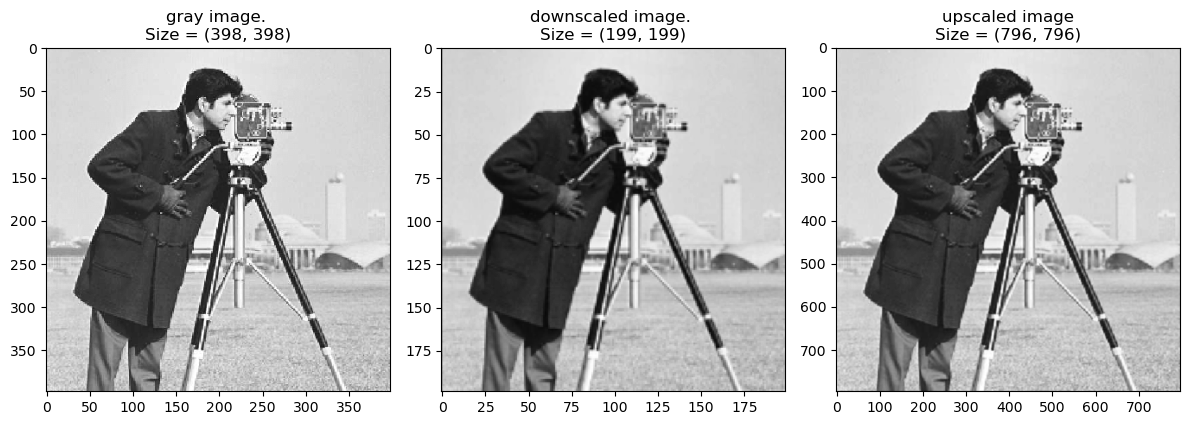

In [6]:
# Create a subplot where we will show 3 images: the original gray scale, the downscaled and the upscaled
fig, axes = plt.subplots(1, 3, figsize = (12,6))

downscale = 2 # This value can be changed depending on how big / small we want the image to be
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Convert to grayscale
down_img = downscale_image(gray_image, 1/downscale) # Perform downscaling
up_img = upscale_image(gray_image, downscale) # Perform upscaling

# Ensure the image data is in the range 0-255
down_image = np.clip(down_img, 0, 255)
up_image = np.clip(up_img, 0, 255)

# Convert the image to uint8
down_image = down_image.astype(np.uint8)
up_image = up_image.astype(np.uint8)

# Plot the 3 images
axes[0].imshow(gray_image, cmap="gray")
axes[0].set_title("gray image. \nSize = " + str(gray_image.shape))

axes[1].imshow(down_image, cmap="gray")
axes[1].set_title("downscaled image. \nSize = " + str(down_img.shape))

axes[2].imshow(up_image, cmap="gray")
axes[2].set_title("upscaled image\nSize = " + str(up_image.shape))

plt.tight_layout()
plt.show()

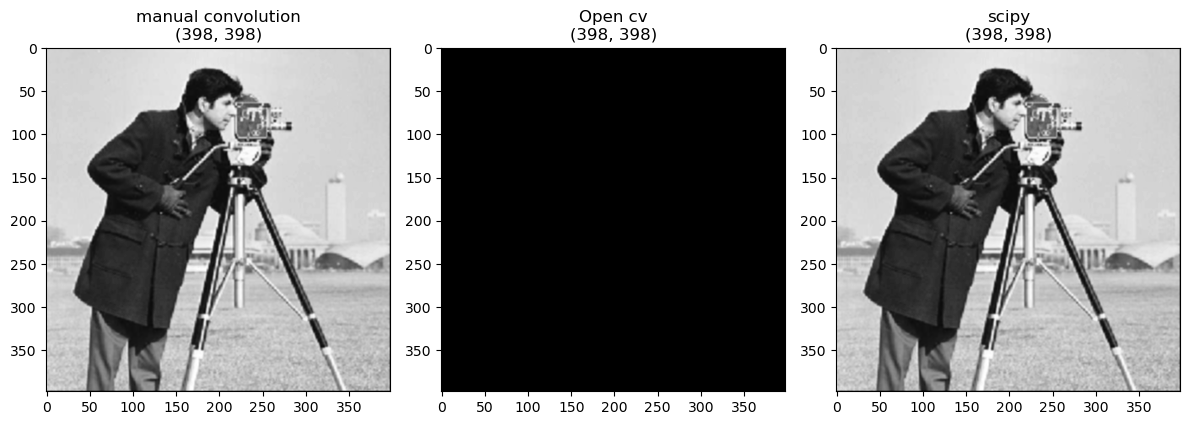

In [9]:
# This line is because in some cases i'm only executing this cell and sometimes i have changed the 
# grayscale image so i want to ensure everytime i run this part, the grayscale is the original
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Plot of subplots to compare our manual convolution to the one that comes in the scipy's library. 
fig, axes = plt.subplots(1, 3, figsize = (12,6))

# We are going to apply this kernel
kernel = np.array([[1, 2, 1],
                   [2, 4, 2],
                   [1, 2, 1]])

# Manual convolution ------------------------------------------------------------------------
result = convolution(gray_image, kernel, stride=1, padding=1)
axes[0].imshow(result, cmap="gray")
axes[0].set_title("manual convolution\n" + str(result.shape))

# Open CV convolution ------------------------------------------------------------------------
'''
gray_image2 = gray_image.astype(np.uint8)
kernel2 = kernel.astype(np.uint8)
'''
opencv_result = cv2.filter2D(gray_image, -1, kernel)
axes[1].imshow(opencv_result, cmap="gray")
axes[1].set_title("Open cv\n" + str(opencv_result.shape))

# Scipy convolution ------------------------------------------------------------------------
from scipy.signal import convolve2d
scipy_result = convolve2d (gray_image, kernel , mode = 'same')
axes[2].imshow(scipy_result, cmap="gray")
axes[2].set_title("scipy\n" + str(scipy_result.shape))

plt.tight_layout()
plt.show()

In [10]:
# Tests ( look if numerical results of the outputs are simmilar )
assert np.allclose (result , scipy_result), "Scipy_mismatch"

## Linear Filtering


#### Objective:
Explore various image filtering techniques by applying them to a set of example images as well as images of your own choice. Experiment with different kernel sizes and types of filters to observe their effects.

- Blur:
  - Average Box Filter
  - Gaussian Filter
- Edge:
  - Laplacian Filter
  - Sobel Filter
  - Prewitt Filter

Feel free to experiment with additional filters as well.

---

#### Guideline:
1. Apply each of the given filters to the example images provided.
2. Use images of your own choosing to further experiment with these filters.
3. Experiment with varying kernel sizes for each filter.
4. Analyze the effects of each filter and kernel size on the images.

---

#### Expected results:
- Filtered images (both example and your own)
- Analysis of the effect of kernel size


Examples of different linear filters for blur and edge *detection*

1. **Average Box Filter:**
   ```
   1/9  1/9  1/9
   1/9  1/9  1/9
   1/9  1/9  1/9
   ```

2. **Gaussian Blur Filter:**
   ```
   1/16  2/16  1/16
   2/16  4/16  2/16
   1/16  2/16  1/16
   ```

3. **Laplacian Filter:**
   ```
   0  1  0
   1 -4  1
   0  1  0
   ```

4. **Sobel Operator (horizontal || vertical):**
  ```
     -1  0  1  ||  -1 -2 -1
     -2  0  2  ||   0  0  0
     -1  0  1  ||   1  2  1
  ```

5. **Prewitt Operator (horizontal || vertical):**
   ```
    -1  0  1  || -1 -1 -1
    -1  0  1  ||  0  0  0
    -1  0  1  ||  1  1  1
   ```



In [11]:
def apply_linear_filter(image, kernel):
    output = convolution(image, kernel, stride=1, padding=1)
    return output

# Create the kernels
average_box_filter = np.array([[1/9, 1/9, 1/9], 
                               [1/9, 1/9, 1/9], 
                               [1/9, 1/9, 1/9]])
gausian_blur_filter = np.array([[1/16, 2/16, 1/16], 
                                [2/16, 4/16, 2/16], 
                                [1/16, 2/16, 1/16]])
laplacian_filter = np.array([[0, 1, 0], 
                             [1, -4, 1], 
                             [0, 1, 0]])
sobel_operator_h = np.array([[-1, 0, -1], 
                             [-2, 0, 2], 
                             [-1, 0, 1]])
sobel_operator_v = sobel_operator_h.T
prewitt_operator_h = np.array([[-1, 0, 1], 
                               [-1, 0, 1], 
                               [-1, 0, 1]])
prewitt_operator_v = prewitt_operator_h.T

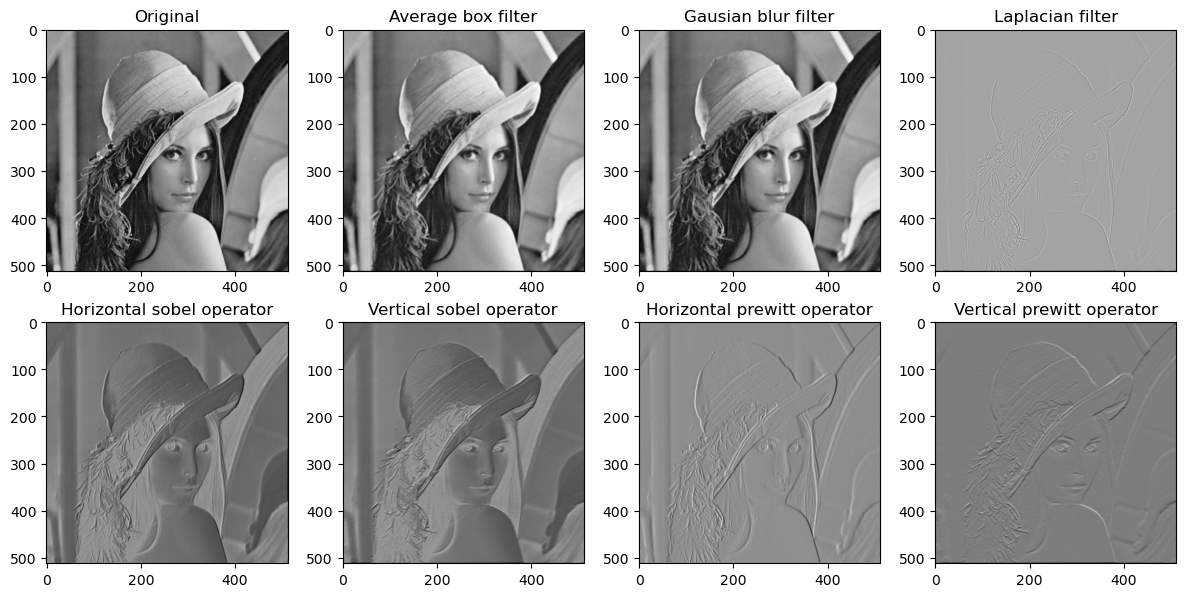

In [12]:
img = cv2.imread("C:/Users/Momo/OneDrive/Escriptori/Computer vision/Lab 1/images/lenna.png")
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply each kernel
fig, axes = plt.subplots(2, 4, figsize = (12,6))
axes[0][0].imshow(gray_image, cmap="gray")
axes[0][0].set_title("Original")

axes[0][1].imshow(apply_linear_filter (gray_image, average_box_filter), cmap="gray")
axes[0][1].set_title("Average box filter")

axes[0][2].imshow(apply_linear_filter (gray_image, gausian_blur_filter), cmap="gray")
axes[0][2].set_title("Gausian blur filter")

axes[0][3].imshow(apply_linear_filter (gray_image, laplacian_filter), cmap="gray")
axes[0][3].set_title("Laplacian filter")

axes[1][0].imshow(apply_linear_filter (gray_image, sobel_operator_h), cmap="gray")
axes[1][0].set_title("Horizontal sobel operator")

axes[1][1].imshow(apply_linear_filter (gray_image, sobel_operator_v), cmap="gray")
axes[1][1].set_title("Vertical sobel operator")

axes[1][2].imshow(apply_linear_filter (gray_image, prewitt_operator_h), cmap="gray")
axes[1][2].set_title("Horizontal prewitt operator")

axes[1][3].imshow(apply_linear_filter (gray_image, prewitt_operator_v), cmap="gray")
axes[1][3].set_title("Vertical prewitt operator")

plt.tight_layout()
plt.show()

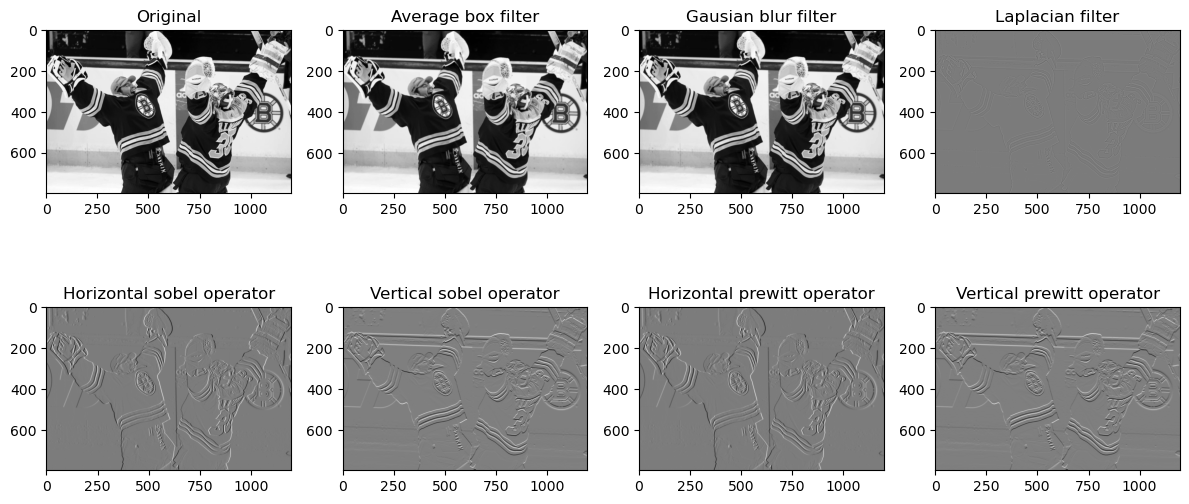

In [13]:
# Now let's try with another image and 4x4 kernels:
average_box_filter = np.array([[1/9, 1/9, 1/9], 
                               [1/9, 1/9, 1/9], 
                               [1/9, 1/9, 1/9], 
                               [1/9, 1/9, 1/9]])
gausian_blur_filter = np.array([[1/256, 4/256, 6/256, 4/256],
                                [4/256, 16/256, 24/256, 16/256],
                                [6/256, 24/256, 36/256, 24/256],
                                [4/256, 16/256, 24/256, 16/256]])
laplacian_filter = np.array([[0, 0, 1, 0, 0],
                             [0, 1, 2, 1, 0],
                             [1, 2, -16, 2, 1],
                             [0, 1, 2, 1, 0],
                             [0, 0, 1, 0, 0]])
sobel_operator_h = np.array([[-1, 0, 0, 1],
                             [-2, 0, 0, 2],
                             [-2, 0, 0, 2],
                             [-1, 0, 0, 1]])
sobel_operator_v = sobel_operator_h.T
prewitt_operator_h = np.array([[-1, 0, 0, 1], 
                               [-1, 0, 0, 1], 
                               [-1, 0, 0, 1], 
                               [-1, 0, 0, 1]])
prewitt_operator_v = prewitt_operator_h.T

hcky = cv2.imread("C:/Users/Momo/OneDrive/Escriptori/Computer vision/descarga.jpg")
gray_image = cv2.cvtColor(hcky, cv2.COLOR_BGR2GRAY)

fig, axes = plt.subplots(2, 4, figsize = (12,6))
axes[0][0].imshow(gray_image, cmap="gray")
axes[0][0].set_title("Original")

axes[0][1].imshow(apply_linear_filter (gray_image, average_box_filter), cmap="gray")
axes[0][1].set_title("Average box filter")

axes[0][2].imshow(apply_linear_filter (gray_image, gausian_blur_filter), cmap="gray")
axes[0][2].set_title("Gausian blur filter")

axes[0][3].imshow(apply_linear_filter (gray_image, laplacian_filter), cmap="gray")
axes[0][3].set_title("Laplacian filter")

axes[1][0].imshow(apply_linear_filter (gray_image, sobel_operator_h), cmap="gray")
axes[1][0].set_title("Horizontal sobel operator")

axes[1][1].imshow(apply_linear_filter (gray_image, sobel_operator_v), cmap="gray")
axes[1][1].set_title("Vertical sobel operator")

axes[1][2].imshow(apply_linear_filter (gray_image, prewitt_operator_h), cmap="gray")
axes[1][2].set_title("Horizontal prewitt operator")

axes[1][3].imshow(apply_linear_filter (gray_image, prewitt_operator_v), cmap="gray")
axes[1][3].set_title("Vertical prewitt operator")

plt.tight_layout()
plt.show()

## Template matching


#### **Objective:**
Implement template matching system using normalized cross-correlations (NCC). You need to identify multiple templates within a given image and draw bounding boxes around the identified regions.

---

#### Guidelines:
1. Implement the normalized cross-correlation algorithm. Your function should accept an image and a template as parameters. DO NOT USE LIBRARIES.
3. Use a folder containing multiple templates to attempt to identify all templates within a given test image.
4. Draw bounding boxes around the identified template regions in the test image.
---

#### Expected result:
- A test image with bounding boxes around identified templates

In [14]:
def normalized_cross_correlation(image, template):
    # Initialize an empty array 'ncc_map'
    ncc_map = np.zeros((image.shape[0] - template.shape[0] + 1, image.shape[1] - template.shape[1] + 1))

    for i in range(ncc_map.shape[0]):
        for j in range(ncc_map.shape[1]):
            # Extract a patch from 'image' at (i, j) of the same size as 'template'
            patch = image[i:i + template.shape[0], j:j + template.shape[1]]
            
            # Compute mean_p and mean_t for the patch and template
            mean_p = np.mean(patch)
            mean_t = np.mean(template)
            
            # Calculate ncc for the patch
            num = np.sum((patch - mean_p) * (template - mean_t))
            den = np.std(patch) * np.std(template)
            if den != 0:
                ncc = num / den
            else:   # So that the division isn't done by 0
                ncc = 0  
            ncc_map[i, j] = ncc
    return ncc_map

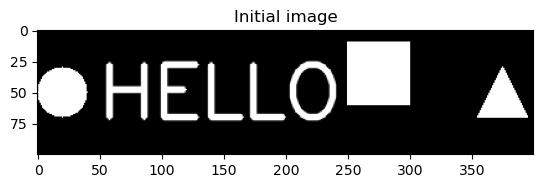

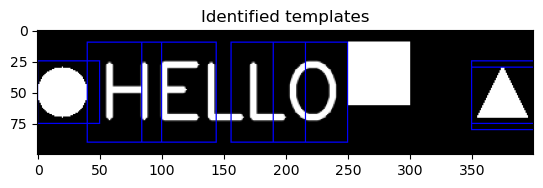

In [15]:
# Load all images
image = cv2.imread("C:/Users/Momo/OneDrive/Escriptori/Computer vision/Lab 1/images/template/template_example.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image, cmap='gray')
plt.title('Initial image')
plt.show()

H = cv2.imread("C:/Users/Momo/OneDrive/Escriptori/Computer vision/Lab 1/images/template/template_H.png")
L = cv2.imread("C:/Users/Momo/OneDrive/Escriptori/Computer vision/Lab 1/images/template/template_L.png")
O = cv2.imread("C:/Users/Momo/OneDrive/Escriptori/Computer vision/Lab 1/images/template/template_O.png")
Square = cv2.imread("C:/Users/Momo/OneDrive/Escriptori/Computer vision/Lab 1/images/template/template_Square.png")
Triangle = cv2.imread("C:/Users/Momo/OneDrive/Escriptori/Computer vision/Lab 1/images/template/template_Triangle.png")
Circle = cv2.imread("C:/Users/Momo/OneDrive/Escriptori/Computer vision/Lab 1/images/template/template_Circle.png")
E = cv2.imread("C:/Users/Momo/OneDrive/Escriptori/Computer vision/Lab 1/images/template/template_E.png")

# Create a list so that we can do a for loop and work with all of them in less lines
templates = [H, E, L, O, Square, Triangle, Circle]
bounding_boxes = []

for figure in templates:
    # Convert to grayscale
    figure = cv2.cvtColor(figure, cv2.COLOR_BGR2GRAY)
    # Calculate the normalized cross-correlation map
    ncc_map = normalized_cross_correlation(image, figure)
    
    #we normalise the ncc_map, this way all the values are between 0 and 1. 
    ncc_map = (ncc_map - np.min(ncc_map)) / (np.max(ncc_map) - np.min(ncc_map))
    
    # Set a threshold to determine separate when we have a mtaching
    threshold = 1
    # If i set the value to 0.9, the l is detected but the circle and the triangle are found multiple times
    # Instead, if the threshold is 1, the L is not detected but the circle and triangle are found less times
    
    # Find template matches using the threshold
    loc = np.where(ncc_map >= threshold)
    # Create bounding boxes for the matches
    for point in zip(*loc[::-1]): # We get both coordinates of the loc array (reversed)
        bottom_right = (point[0] + figure.shape[1], point[1] + figure.shape[0])
        bounding_boxes.append((point, bottom_right))

image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
# Draw bounding boxes on the test image
for (start_point, end_point) in bounding_boxes:
    cv2.rectangle(image, start_point, end_point, (0, 0, 255), 1)

plt.imshow(image, cmap='gray')
plt.title('Identified templates')
plt.show()  # Display the plot

## Fourier Transform



#### **Objective**:
You are provided with three images, each corrupted by one or more periodic frequencies. Your task is to process these images using Fourier Transform techniques to identify and remove the corrupting frequencies.

- Image 1 has one specific corrupting frequency.
- Image 2 has another unique corrupting frequency.
- Image 3 has both frequencies from Image 1 and Image 2.

---

#### Guideline:
1. Use Fourier Transform to convert each image to the frequency domain. (you can use libraries for this)
2. Analyze the Fourier spectrum to identify the corrupting frequencies.
3. Remove the identified frequencies and perform an Inverse Fourier Transform to obtain the cleaned image.
4. Compare the cleaned images with the original corrupted ones and quantify the improvements.

---
#### Expected results:
- Cleaned images


In [84]:
pic1 = cv2.imread("C:/Users/Momo/OneDrive/Escriptori/Computer vision/Lab 1/images/fourier/fourier_1.jpg")
pic2 = cv2.imread("C:/Users/Momo/OneDrive/Escriptori/Computer vision/Lab 1/images/fourier/fourier_2.jpg")
pic3 = cv2.imread("C:/Users/Momo/OneDrive/Escriptori/Computer vision/Lab 1/images/fourier/fourier_3.jpg")
pics = [pic1, pic2, pic3]

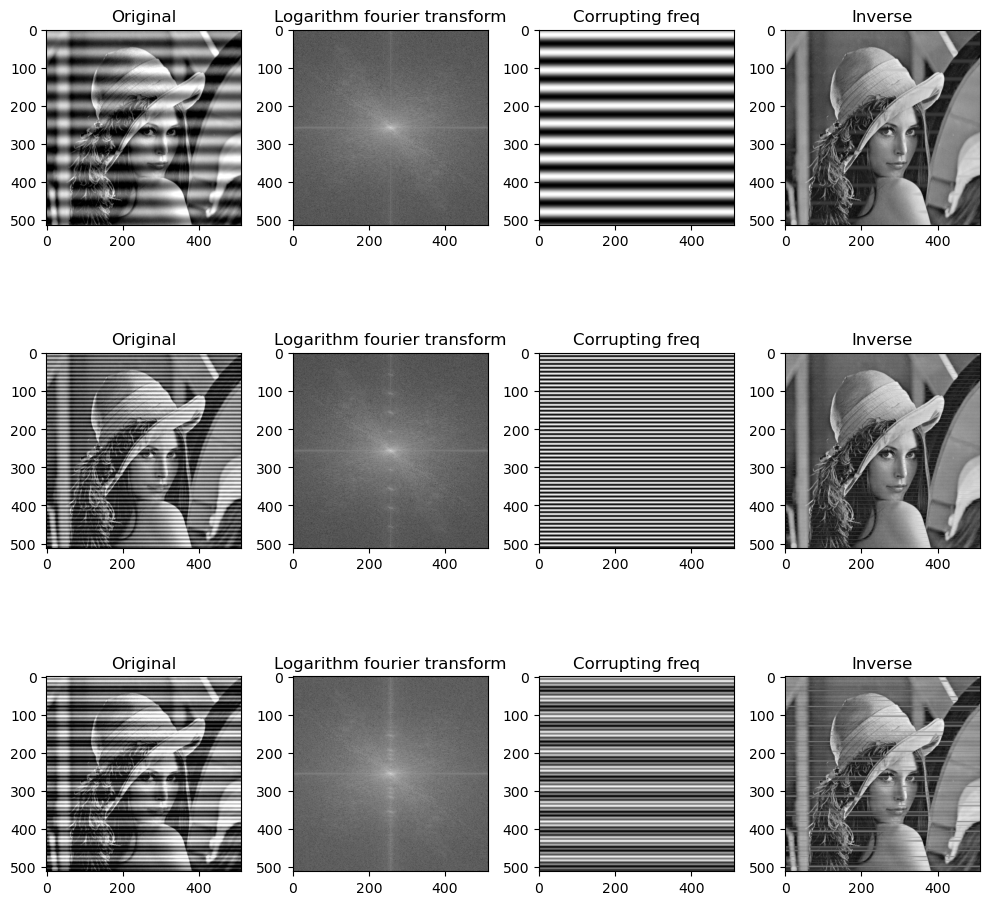

In [95]:
fig, axes = plt.subplots(3, 4, figsize=(10, 10))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, hspace=0.3, wspace=0.3)

for i in range (3):
    pic = pics[i]
    img = cv2.cvtColor(pic, cv2.COLOR_BGR2GRAY)

    # GET FREQUENCY DOMAIN-----------------------------------------------------------------------------------------------------
    f = np.fft.fft2(img) # Fast fourier transform
    fs = np.fft.fftshift(f) # Shift function (0 freq component on the center of the image)
    lfs = 15 * np.log(1 + np.abs(fs)) 
    # Enhance the visualization of the magnitude of the FFT. The logarithmic scaling is often applied to make the features more visible

    # APPLY MASK-----------------------------------------------------------------------------------------------------
    threshold = np.max(lfs) * 0.9
    # Find the coordinates of all points above the threshold
    points = np.where(lfs > threshold)
    # Create an empty (black) mask with the same size as `lfs`
    mask = np.full((lfs.shape[0], lfs.shape[1]), 0)
    # Set these positions in the mask to 0
    mask[points] = 1
    # Apply the mask to the shifted Fourier transform
    masked_fs = fs * mask
    # Now we only have the corrupting frequency

    # INVERSE ON CORRUPTING FREQ-----------------------------------------------------------------------------------------------------
    ishift_img = np.fft.ifftshift(masked_fs) # Inverse shift operation (prepare for the inverse FFT) (fs)
    ifft_img = np.fft.ifft2(ishift_img) # Inverse fourier (to spatial domain)
    abs_img = np.abs(ifft_img) # Obtain the magnitude of the reconstructed image. The magnitude represents the pixel intensity values of the image

    # SUBTRACTION OF THE ORIGINAL AND THE FREQ 
    clean_fs = fs-masked_fs # Subtract original (freq domain) - Corrupting frequencies (freq domain)
    # Shift back the clean image
    clean_f = np.fft.ifftshift(clean_fs)
    # Do the inverse Fourier transform
    clean_img = np.fft.ifft2(clean_f)
    # Simplify taking the real part
    clean_img = np.real(clean_img)
    
    # PLOT-----------------------------------------------------------------------------------------------------
    axes[i][0].imshow(img , cmap="gray")
    axes[i][0].set_title("Original")
    axes[i][1].imshow(lfs , cmap="gray")
    axes[i][1].set_title("Logarithm fourier transform")
    axes[i][2].imshow(abs_img , cmap="gray")
    axes[i][2].set_title("Corrupting freq")
    axes[i][3].imshow(clean_img , cmap="gray")
    axes[i][3].set_title("Inverse")
plt.tight_layout()
plt.show()